<a href="https://colab.research.google.com/github/josamhany/Irregation-Optimization-Project/blob/main/Water_Needed_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
!pip install catboost

In [92]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score
import json
import joblib
from catboost import CatBoostRegressor

In [93]:
merged_df = pd.read_csv('/content/Final_irregation_optimization_data_m2.csv')

In [94]:
merged_df.head()

,soil_moisture,temperature,soil_humidity,time,air_temperature_(c),wind_speed_(km/h),humidity,wind_gust_(km/h),pressure_(kpa),ph,...,ph_category,ph_encoded,crop_encoded,moisture_temp_ratio,evapo_ratio,rain_effect,moisture_change_rate,temp_scaled,npk_balance,wind_ratio
0,54.0,22.0,70.0,21.0,19.52,2.13,55.04,6.30,101.50,6.502985,...,Neutral,1,0.569876,2.347826,683.561290,30224.312898,0.000000,-0.107826,58.333333,0.291781
1,12.0,20.0,40.0,104.0,19.49,2.01,55.17,10.46,101.50,7.038096,...,Neutral,1,0.472449,0.571429,848.769231,48652.866185,0.000000,-0.024286,61.333333,0.175393
2,34.0,26.0,35.0,62.0,19.47,1.90,55.30,14.63,101.51,7.840207,...,Alkaline,2,0.472449,1.259259,729.318841,60702.339593,0.628571,-0.241852,53.000000,0.121561
3,7.0,44.0,44.0,93.0,19.54,2.28,54.20,16.08,101.51,6.980401,...,Neutral,1,0.472449,0.155556,2057.474510,57282.890868,-3.375000,-0.543556,49.666667,0.133489
4,50.0,38.0,23.0,92.0,19.61,2.66,53.09,17.52,101.51,7.628473,...,Alkaline,2,0.472449,1.282051,635.625479,55884.533974,0.843137,-0.471538,54.000000,0.143629


In [95]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   soil_moisture             100000 non-null  float64
 1   temperature               100000 non-null  float64
 2   soil_humidity             100000 non-null  float64
 3   time                      100000 non-null  float64
 4   air_temperature_(c)       100000 non-null  float64
 5   wind_speed_(km/h)         100000 non-null  float64
 6   humidity                  100000 non-null  float64
 7   wind_gust_(km/h)          100000 non-null  float64
 8   pressure_(kpa)            100000 non-null  float64
 9   ph                        100000 non-null  float64
 10  rainfall                  100000 non-null  float64
 11  n                         100000 non-null  float64
 12  p                         100000 non-null  float64
 13  k                         100000 non-null  fl

In [96]:
merged_df.describe()

,soil_moisture,temperature,soil_humidity,time,air_temperature_(c),wind_speed_(km/h),humidity,wind_gust_(km/h),pressure_(kpa),ph,...,nk_ratio,ph_encoded,crop_encoded,moisture_temp_ratio,evapo_ratio,rain_effect,moisture_change_rate,temp_scaled,npk_balance,wind_ratio
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,45.484070,22.536100,45.016790,55.253650,24.240188,9.886338,58.640681,41.678999,101.131310,6.496485,...,1.303589,0.48929,0.536500,4.321199,702.499905,8079.660946,-1.093341,1.396450,50.319729,0.243587
std,25.993998,13.251352,14.726676,32.093033,4.225627,2.712243,18.784521,15.107778,0.136599,0.364238,...,0.681467,0.50761,0.087820,8.693697,575.859261,8493.856953,3.898629,4.099008,12.229497,0.058023
min,1.000000,0.000000,20.000000,0.000000,11.220000,0.000000,0.590000,0.000000,100.500000,3.504752,...,0.000000,0.00000,0.363167,0.021739,0.000000,-2024.817146,-44.500000,-0.711087,5.666667,0.000000
25%,23.000000,11.000000,32.000000,28.000000,21.404000,8.288000,47.904000,32.041500,101.054000,6.253733,...,0.756010,0.00000,0.423383,0.977778,259.440737,2692.619983,-0.904762,-0.283823,41.333333,0.209169
50%,45.000000,23.000000,45.000000,55.000000,23.930000,9.770000,59.282000,40.800000,101.128000,6.488283,...,1.255102,0.00000,0.573977,1.933333,575.115117,6055.267593,0.000000,0.074618,48.933333,0.230948
75%,68.000000,34.000000,58.000000,83.000000,26.586000,11.330000,70.540000,49.956500,101.206000,6.733716,...,1.758333,1.00000,0.573977,3.750000,998.164241,10793.289919,0.473684,1.099534,57.933333,0.260373
max,90.000000,45.000000,70.000000,110.000000,45.560000,31.360000,96.000000,133.330000,101.860000,8.985348,...,9.333327,2.00000,0.699634,90.000000,4155.870968,87850.054964,0.978022,41.400000,126.666667,0.614812


In [97]:
merged_df.isnull().sum()

,0
soil_moisture,0
temperature,0
soil_humidity,0
time,0
air_temperature_(c),0
wind_speed_(km/h),0
humidity,0
wind_gust_(km/h),0
pressure_(kpa),0
ph,0


In [98]:
merged_df.duplicated().sum()

np.int64(0)

In [99]:
merged_df.columns

Index(['soil_moisture', 'temperature', 'soil_humidity', 'time',
       'air_temperature_(c)', 'wind_speed_(km/h)', 'humidity',
       'wind_gust_(km/h)', 'pressure_(kpa)', 'ph', 'rainfall', 'n', 'p', 'k',
       'status', 'crop', 'soil_moisture_diff', 'Relative_Soil_Saturation',
       'temp_diff', 'wind_effect', 'Evapotranspiration', 'rain_3days',
       'rain_vs_soil', 'np_ratio', 'nk_ratio', 'ph_category', 'ph_encoded',
       'crop_encoded', 'moisture_temp_ratio', 'evapo_ratio', 'rain_effect',
       'moisture_change_rate', 'temp_scaled', 'npk_balance', 'wind_ratio'],
      dtype='object')

In [100]:
model = joblib.load('catboost_model.pkl')

In [101]:
    X = merged_df.drop(columns=['status'])

In [102]:
merged_df.columns

Index(['soil_moisture', 'temperature', 'soil_humidity', 'time',
       'air_temperature_(c)', 'wind_speed_(km/h)', 'humidity',
       'wind_gust_(km/h)', 'pressure_(kpa)', 'ph', 'rainfall', 'n', 'p', 'k',
       'status', 'crop', 'soil_moisture_diff', 'Relative_Soil_Saturation',
       'temp_diff', 'wind_effect', 'Evapotranspiration', 'rain_3days',
       'rain_vs_soil', 'np_ratio', 'nk_ratio', 'ph_category', 'ph_encoded',
       'crop_encoded', 'moisture_temp_ratio', 'evapo_ratio', 'rain_effect',
       'moisture_change_rate', 'temp_scaled', 'npk_balance', 'wind_ratio'],
      dtype='object')

In [103]:
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_

In [104]:
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
print(fi_df)

                     Feature  Importance
0              soil_humidity   14.310028
1              soil_moisture    8.699291
2                temperature    7.094101
3                          p    6.297137
4                          k    5.875199
5        moisture_temp_ratio    5.551749
6                   rainfall    5.208675
7   Relative_Soil_Saturation    4.877254
8                 ph_encoded    4.347471
9                          n    4.338942
10                  nk_ratio    4.328087
11                wind_ratio    4.059156
12               npk_balance    3.421984
13                  np_ratio    2.749549
14               evapo_ratio    2.479296
15              rain_vs_soil    2.334337
16                rain_3days    2.316347
17      moisture_change_rate    2.298198
18               rain_effect    2.092578
19                 temp_diff    1.991337
20        Evapotranspiration    1.842038
21               temp_scaled    1.791301
22              crop_encoded    1.695946


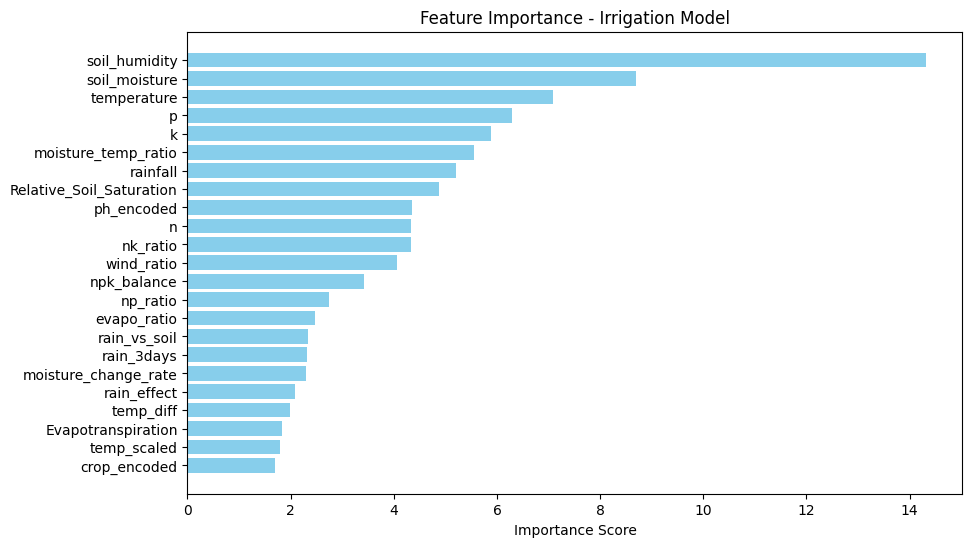

In [105]:
plt.figure(figsize=(10,6))
plt.barh(fi_df['Feature'], fi_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.title('Feature Importance - Irrigation Model')
plt.show()

In [106]:
# Initialize columns
merged_df['recommended_water_mm'] = 0.0
merged_df['soil_moisture_updated'] = merged_df['soil_moisture']
merged_df['recommended_N'] = 0.0
merged_df['recommended_P'] = 0.0
merged_df['recommended_K'] = 0.0

In [107]:
merged_df['crop'].unique()

array(['coffee', 'rice', 'pigeonpeas', 'kidneybeans', 'chickpea',
       'mothbeans', 'lentil', 'mango', 'maize', 'jute', 'grapes',
       'blackgram', 'papaya', 'cotton', 'banana', 'mungbean', 'apple',
       'orange', 'coconut', 'pomegranate', 'watermelon'], dtype=object)

In [108]:
# Primary values
crop_Kc = {
    'rice': 1.2,
    'maize': 1.15,
    'chickpea': 0.9,
    'kidneybeans': 0.95,
    'pigeonpeas': 0.9,
    'mothbeans': 0.85,
    'mungbean': 0.85,
    'blackgram': 0.85,
    'lentil': 0.85,
    'pomegranate': 0.9,
    'banana': 1.1,
    'mango': 0.95,
    'grapes': 0.95,
    'watermelon': 0.9,
    'muskmelon': 0.9,
    'apple': 0.95,
    'orange': 0.95,
    'papaya': 1.0,
    'coconut': 1.0,
    'cotton': 1.0,
    'jute': 1.0,
    'coffee': 1.0,
}
crop_NPK_max = {
    'rice': {'N':12, 'P':6, 'K':8},
    'maize': {'N':10, 'P':5, 'K':7},
    'chickpea': {'N':8, 'P':4, 'K':6},
    'kidneybeans': {'N':9, 'P':4, 'K':6},
    'pigeonpeas': {'N':9, 'P':4, 'K':6},
    'mothbeans': {'N':8, 'P':3, 'K':5},
    'mungbean': {'N':8, 'P':3, 'K':5},
    'blackgram': {'N':8, 'P':3, 'K':5},
    'lentil': {'N':8, 'P':3, 'K':5},
    'pomegranate': {'N':10, 'P':5, 'K':7},
    'banana': {'N':10, 'P':5, 'K':8},
    'mango': {'N':10, 'P':5, 'K':7},
    'grapes': {'N':10, 'P':5, 'K':7},
    'watermelon': {'N':9, 'P':4, 'K':6},
    'muskmelon': {'N':9, 'P':4, 'K':6},
    'apple': {'N':10, 'P':5, 'K':7},
    'orange': {'N':10, 'P':5, 'K':8},
    'papaya': {'N':10, 'P':5, 'K':7},
    'coconut': {'N':9, 'P':4, 'K':7},
    'cotton': {'N':8, 'P':4, 'K':6},
    'jute': {'N':8, 'P':4, 'K':6},
    'coffee': {'N':10, 'P':5, 'K':8},
}


In [109]:
# Root zone depth and field capacity
root_zone_depth = 200  # mm
field_capacity = 100   # %

In [110]:
# Safe division function
def safe_divide(a, b):
    if b == 0 or pd.isna(b):
        return a
    return a / b

In [111]:
# Function to calculate irrigation based on ETc (ETc = Evapotranspiration × Kc (FAO standard))
def calculate_irrigation(row):
    if not row['status']:
        return 0
    crop = row['crop']
    Kc = crop_Kc.get(crop, 1.0)

    ETc = row['Evapotranspiration'] * Kc
    soil_water_available = (row['soil_moisture_updated'] / 100) * root_zone_depth
    rain_effect = row['rain_3days']

    water_deficit = max(ETc - soil_water_available - rain_effect, 0)

    # Adjust based on soil moisture
    if row['soil_moisture_updated'] < 30:
        water_deficit *= 1.2
    elif row['soil_moisture_updated'] > 70:
        water_deficit *= 0.5

    # Limit water to realistic daily max
    max_irrigation = 50
    return round(min(water_deficit, max_irrigation), 2)

In [112]:
# Function to calculate NPK recommendation
def calculate_npk(row, irrigation_mm):
    crop = row['crop']
    N_max = crop_NPK_max.get(crop, {'N':10,'P':5,'K':7})['N']
    P_max = crop_NPK_max.get(crop, {'N':10,'P':5,'K':7})['P']
    K_max = crop_NPK_max.get(crop, {'N':10,'P':5,'K':7})['K']

    # Adjust NPK safely
    N = safe_divide(N_max, row.get('np_ratio',1))
    P = safe_divide(P_max, row.get('npk_balance',1))
    K = safe_divide(K_max, row.get('nk_ratio',1))

    # Adjust for pH
    ph = row.get('ph',7)
    if ph < 5.5 or ph > 7.5:
        N *= 0.8
        P *= 0.8
        K *= 0.8

    # Scale by irrigation (more water → more nutrient uptake)
    factor = irrigation_mm / 50
    N *= factor
    P *= factor
    K *= factor

    return round(N,2), round(P,2), round(K,2)

In [113]:
# Simulation per day
water_list = []
soil_moisture_list = []
N_list, P_list, K_list = [], [], []

for idx, row in merged_df.iterrows():
    water = calculate_irrigation(row)
    water_list.append(water)

    # Update soil moisture
    new_moisture = row['soil_moisture_updated'] + (water + row['rain_3days']) * 100 / root_zone_depth
    new_moisture = min(new_moisture, field_capacity)
    soil_moisture_list.append(new_moisture)

    # NPK recommendation
    N, P, K = calculate_npk(row, water)
    N_list.append(N)
    P_list.append(P)
    K_list.append(K)

    # Update next row moisture
    if idx+1 < len(merged_df):
        merged_df.at[idx+1, 'soil_moisture_updated'] = new_moisture

In [114]:
merged_df['recommended_water_mm'] = water_list
merged_df['soil_moisture_updated'] = soil_moisture_list
merged_df['recommended_N'] = N_list
merged_df['recommended_P'] = P_list
merged_df['recommended_K'] = K_list
merged_df.to_csv('irrigation_npk_scientific_safe.csv', index=False)

In [115]:
merged_df.head()

,soil_moisture,temperature,soil_humidity,time,air_temperature_(c),wind_speed_(km/h),humidity,wind_gust_(km/h),pressure_(kpa),ph,...,rain_effect,moisture_change_rate,temp_scaled,npk_balance,wind_ratio,recommended_water_mm,soil_moisture_updated,recommended_N,recommended_P,recommended_K
0,54.0,22.0,70.0,21.0,19.52,2.13,55.04,6.30,101.50,6.502985,...,30224.312898,0.000000,-0.107826,58.333333,0.291781,50.0,79.0,4.67,0.09,3.82
1,12.0,20.0,40.0,104.0,19.49,2.01,55.17,10.46,101.50,7.038096,...,48652.866185,0.000000,-0.024286,61.333333,0.175393,0.0,12.0,0.00,0.00,0.00
2,34.0,26.0,35.0,62.0,19.47,1.90,55.30,14.63,101.51,7.840207,...,60702.339593,0.628571,-0.241852,53.000000,0.121561,50.0,100.0,8.80,0.09,4.69
3,7.0,44.0,44.0,93.0,19.54,2.28,54.20,16.08,101.51,6.980401,...,57282.890868,-3.375000,-0.543556,49.666667,0.133489,0.0,100.0,0.00,0.00,0.00
4,50.0,38.0,23.0,92.0,19.61,2.66,53.09,17.52,101.51,7.628473,...,55884.533974,0.843137,-0.471538,54.000000,0.143629,0.0,100.0,0.00,0.00,0.00


In [116]:
features = [
    'soil_moisture', 'temperature', 'soil_humidity', 'air_temperature_(c)',
    'wind_speed_(km/h)', 'humidity', 'wind_gust_(km/h)', 'pressure_(kpa)',
    'ph', 'rainfall', 'n', 'p', 'k', 'soil_moisture_diff',
    'Relative_Soil_Saturation', 'temp_diff', 'wind_effect',
    'Evapotranspiration', 'rain_3days', 'rain_vs_soil',
    'np_ratio', 'nk_ratio', 'ph_encoded', 'crop_encoded',
    'moisture_temp_ratio', 'evapo_ratio', 'rain_effect',
    'moisture_change_rate', 'temp_scaled', 'npk_balance', 'wind_ratio'
] # We removed any features have a high correlation with our own target

target = 'recommended_water_mm'


In [117]:
x = merged_df[merged_df['status']== True][features] # Predict the water needed while the status = True only (soil need water)
y = merged_df[merged_df['status']== True][target]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [118]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    eval_metric='R2',
    random_seed=42,
    verbose=200
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 0.0840764	test: 0.0844820	best: 0.0844820 (0)	total: 42.5ms	remaining: 42.5s
200:	learn: 0.9781083	test: 0.9688939	best: 0.9688939 (200)	total: 6.47s	remaining: 25.7s
400:	learn: 0.9859901	test: 0.9725317	best: 0.9725317 (400)	total: 14.1s	remaining: 21s
600:	learn: 0.9900324	test: 0.9736148	best: 0.9736148 (600)	total: 21.7s	remaining: 14.4s
800:	learn: 0.9926996	test: 0.9741720	best: 0.9741720 (800)	total: 28.9s	remaining: 7.17s
999:	learn: 0.9945095	test: 0.9744071	best: 0.9744287 (952)	total: 39.5s	remaining: 0us

bestTest = 0.9744286917
bestIteration = 952

Shrink model to first 953 iterations.


In [119]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 MAE: {mae:.3f}")
print(f"📉 RMSE: {rmse:.3f}")
print(f"🎯 R² Score: {r2:.3f}")

📊 MAE: 0.683
📉 RMSE: 6.777
🎯 R² Score: 0.974


In [120]:
n = len(y_test)
p = len(features)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R² =", adj_r2)

Adjusted R² = 0.9743545927074728


In [121]:
merged_df[merged_df['status'] == False]['recommended_water_mm'].value_counts()

,count
recommended_water_mm,
0.0,46350
